In [1]:
import pandas as pd
import os
import json
import yfinance as yf # THIS API IS SO COOL, HAS EVERYTHING I NEED
from lets_plot import *
LetsPlot.setup_html()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #sentiment analysis
from bs4 import BeautifulSoup # scraping tool for getting news articles
import time
import requests
from datetime import datetime, time
import pytz
import sqlite3

In [2]:
sentences = ["siddharth is v", "siddharth is the worst"]
analyzer = SentimentIntensityAnalyzer()
sentiments = []
for sentence in sentences:
    sentiments.append(str(analyzer.polarity_scores(sentence)))

sentiments

["{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",
 "{'neg': 0.577, 'neu': 0.423, 'pos': 0.0, 'compound': -0.6249}"]

<Axes: title={'center': 'Oil Future Prices Over Time'}, xlabel='Years', ylabel='USD'>

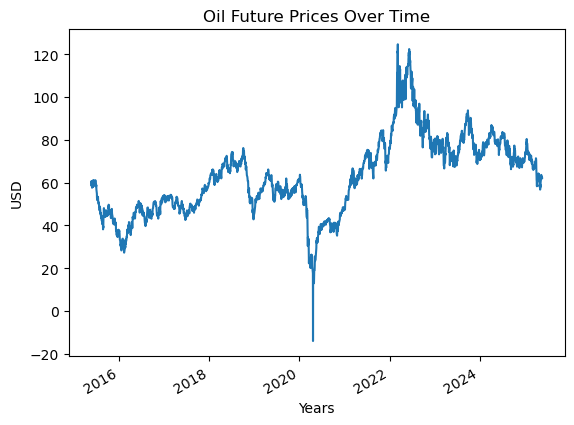

In [17]:
dat = yf.Ticker("CL=F") # oil futures are an accurate way to determine the effect of sentiment

oil_df = dat.history(period="10y")
 
oil_df['Open'].plot(title='Oil Future Prices Over Time', xlabel='Years', ylabel = "USD")

In [4]:
def get_news(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text) 

    headlines = []
    for article in soup.find_all(class_='article_name'):
                headline = article.get_text(strip=True)
                headlines.append(headline)

    dates = []
    for date in soup.find_all(class_='categoryArticle__meta'):
                date_author = date.get_text(strip=True)
                dates.append(date_author)

    raw_dict = dict(zip(dates, headlines))

    grouped_dict = {}

    for full_date_str, headline in raw_dict.items():

        # needed to clean that messy metadata into a datetime format
        date_str = full_date_str.split(' at')[0]
        date_obj = datetime.strptime(date_str, '%b %d, %Y').date()
        datetime_midnight = datetime.combine(date_obj, time(0, 0))
        eastern = pytz.timezone("America/New_York")
        datetime_with_tz = eastern.localize(datetime_midnight)
        #code extracts the date from a string, converts it to a datetime object at midnight, and then localizes it to the Eastern Time Zone

        # grouping news articles by dates
        if str(datetime_with_tz) in grouped_dict:
            grouped_dict[str(datetime_with_tz)].append(headline)
        else:
            grouped_dict[str(datetime_with_tz)] = [headline]
    return grouped_dict

In [5]:
# sentiment analysis function here - goes through the values of the dictionary and replaces them with an aggregate sentiment

def get_sentiments(grouped_dict):
    analyzer = SentimentIntensityAnalyzer()

    # replace every news article with it's sentiment score 
    for key in grouped_dict:
        for i in range(len(grouped_dict[key])):
            grouped_dict[key][i] = analyzer.polarity_scores(grouped_dict[key][i])['compound']

    # average out the sentiments and result one value for each date key
    for key in grouped_dict:
        grouped_dict[key] = sum(grouped_dict[key]) / len(grouped_dict[key])

    return grouped_dict


In [6]:
some_news = get_news("https://oilprice.com/Latest-Energy-News/World-News/Page-1.html")

some_news

{'2025-05-21 00:00:00-04:00': ['Oil Giant Rosneft Buys Russia’s Biggest Rare Earths Deposit',
  'Solar Power Set to Surpass Nuclear Generation This Summer',
  'Turkey Announces Major Shale Oil Reserve Discovery',
  'CATL Predicts Major Shift to Electric Trucks in China',
  'Centrica Divests North Sea Gas Field Stake',
  'Indonesian Pertamina Imports Sanctions-Compliant Russian Crude',
  'Petrobras Plans To Start Drilling in the Amazon in Weeks',
  'U.S. Extends Chevron’s License to Operate in Venezuela'],
 '2025-05-20 00:00:00-04:00': ['US Oil Inventories Keep Growing as Prices Sag',
  'Ukraine Pushes G7 to Cut Russia’s Oil Cap to $30 as Revenues Tank',
  'OPEC Remains Optimistic About Oil Demand Despite Economic Risks',
  'Kazakhstan Defies OPEC+ Once Again',
  'Saudi Arabia Is Prepared for Multiple Oil Price Scenarios',
  'Woodside Sees Global Natural Gas Demand Surging by 50% by 2030',
  'China Customs Data Shows Dramatic Changes in Oil Suppliers',
  'Saudi Crude Burn Set to Rise Th

In [ ]:
# generating a dataframe that utilizes our two functions to show all functions with each date

base_url = "https://oilprice.com/Latest-Energy-News/World-News/Page-{}.html"

all_news = {}
for i in range(1, 1159): #takes a long time to load - DO NOT RUN AGAIN:)
    all_news.update(get_sentiments(get_news(base_url.format(i))))

sentiment_df = pd.DataFrame.from_dict(all_news, orient='index', columns=['Aggregate Sentiment'])

sentiment_df

KeyboardInterrupt: 

In [14]:
oil_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Sentiment
Date,,,,,,,,
2025-02-21 05:00:00+00:00,72.580002,72.769997,70.169998,70.400002,268470,0.0,0.0,0.000000
2025-02-24 05:00:00+00:00,69.800003,70.940002,69.800003,70.699997,205468,0.0,0.0,0.041642
2025-02-25 05:00:00+00:00,70.919998,71.260002,68.680000,68.930000,267310,0.0,0.0,0.000000
2025-02-26 05:00:00+00:00,69.110001,69.279999,68.360001,68.620003,255601,0.0,0.0,-0.036130
2025-02-27 05:00:00+00:00,68.820000,70.540001,68.610001,70.349998,265933,0.0,0.0,0.042455
...,...,...,...,...,...,...,...,...
2025-05-15 04:00:00+00:00,62.880001,62.910000,60.470001,61.619999,258404,0.0,0.0,0.001950
2025-05-16 04:00:00+00:00,61.700001,62.709999,61.250000,62.490002,121556,0.0,0.0,0.028910
2025-05-19 04:00:00+00:00,62.750000,63.400002,61.570000,62.689999,95570,0.0,0.0,-0.009789


In [19]:
sentiment_df

,Aggregate Sentiment
2025-05-21 04:00:00+00:00,-0.033250
2025-05-20 04:00:00+00:00,-0.022342
2025-05-19 04:00:00+00:00,-0.009789
2025-05-16 04:00:00+00:00,0.028910
2025-05-15 04:00:00+00:00,0.001950
...,...
2011-06-21 04:00:00+00:00,-0.053200
2011-06-20 04:00:00+00:00,0.103140
2011-06-19 04:00:00+00:00,0.125000
2011-06-18 04:00:00+00:00,-0.285950


In [20]:
# pandas is lovely, it alligns everything by date, makes it easy to combine the databases - saving to a csv because my sql isn't working???


oil_df.index = pd.to_datetime(oil_df.index, utc=True)
sentiment_df.index = pd.to_datetime(sentiment_df.index, utc=True)

oil_df['Sentiment'] = sentiment_df['Aggregate Sentiment']

oil_df


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Sentiment
Date,,,,,,,,
2015-05-21 04:00:00+00:00,58.810001,60.939999,58.689999,60.720001,329765,0.0,0.0,0.136600
2015-05-22 04:00:00+00:00,60.660000,60.799999,59.349998,59.720001,230307,0.0,0.0,-0.190633
2015-05-26 04:00:00+00:00,60.049999,60.250000,57.709999,58.029999,330128,0.0,0.0,0.192350
2015-05-27 04:00:00+00:00,58.320000,58.950001,57.360001,57.509998,314917,0.0,0.0,-0.047650
2015-05-28 04:00:00+00:00,57.630001,58.070000,56.509998,57.680000,340682,0.0,0.0,0.152950
...,...,...,...,...,...,...,...,...
2025-05-15 04:00:00+00:00,62.880001,62.910000,60.470001,61.619999,258404,0.0,0.0,0.001950
2025-05-16 04:00:00+00:00,61.700001,62.709999,61.250000,62.490002,121556,0.0,0.0,0.028910
2025-05-19 04:00:00+00:00,62.750000,63.400002,61.570000,62.689999,95570,0.0,0.0,-0.009789


In [22]:
oil_df.to_csv('/files/sentiment-project/oil_data.csv')

<Axes: title={'center': 'Oil Price Sentiment Over Time'}, xlabel='Years', ylabel='Sentiment'>

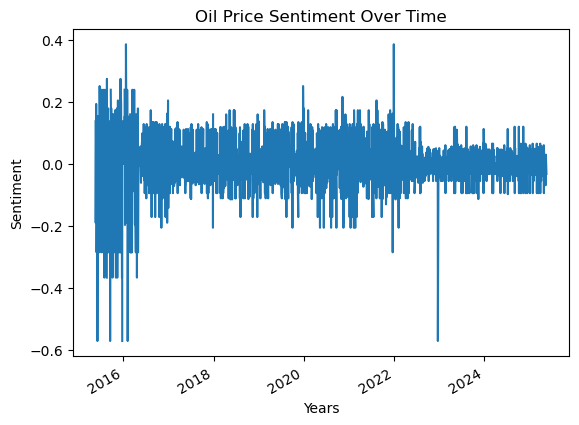

In [ ]:
oil_df['Sentiment'].plot(title='Oil Price Sentiment Over Time', xlabel='Years', ylabel = "Sentiment")

# wow this is not what i expected